<a href="https://colab.research.google.com/github/mjgpinheiro/AI-Strategies-StockMarket/blob/main/Cat_Mouse_strategy_stocks1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Cat's ROI: 4.05%
Mouse's ROI: -14.23%


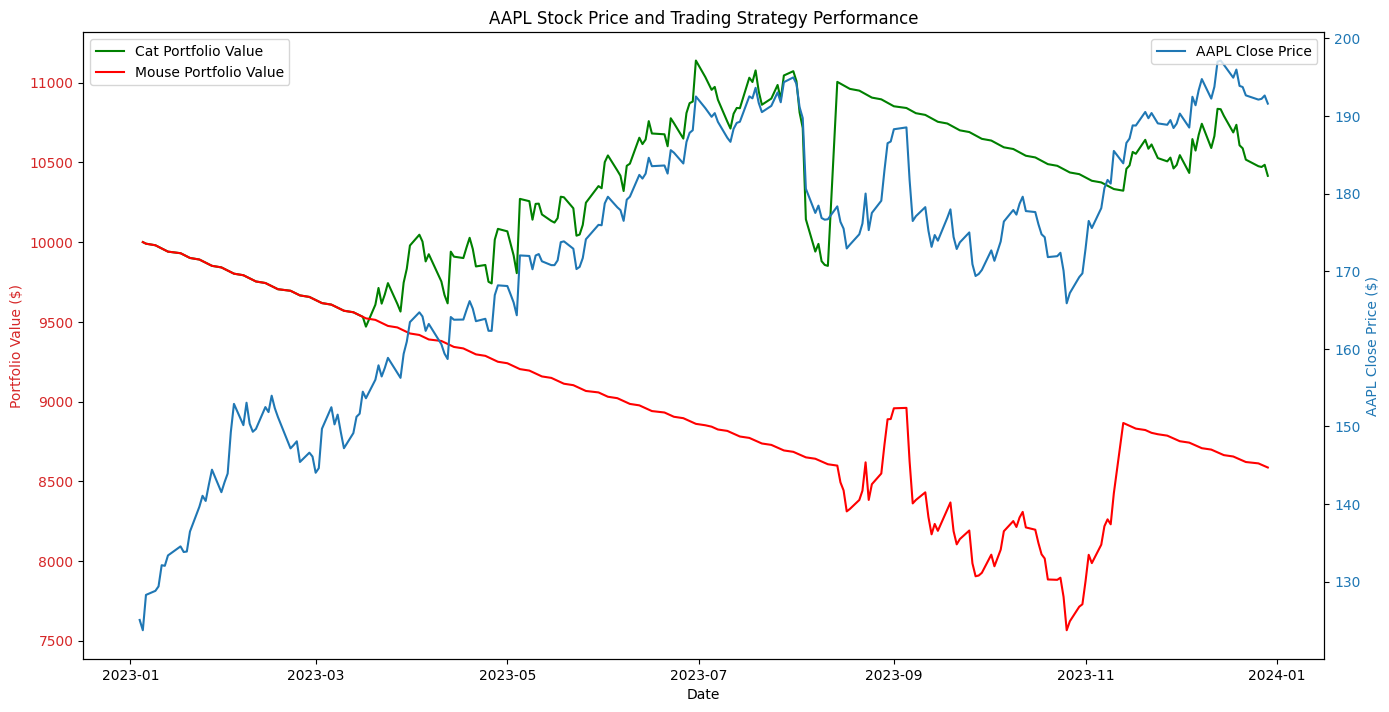

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download Stock Data
data = yf.download('AAPL', start='2023-01-01', end='2024-01-01')
data['Return'] = data['Close'].pct_change()
data.dropna(inplace=True)

# Simulation Parameters
initial_investment = 10000
transaction_cost = 0.001  # 0.1% of the trade amount per trade

# Define Strategy Classes
class Strategy:
    def __init__(self):
        self.cash = initial_investment
        self.position = 0
        self.total_value = initial_investment
        self.portfolio_values = []  # Track portfolio value over time

    def update_position(self, signal, price):
        # Access the scalar value of price using .item()
        price = price.item()
        if signal == 1 and self.cash > 0:  # Buy signal
            self.position = self.cash / price
            self.cash = 0
        elif signal == -1 and self.position > 0:  # Sell signal
            self.cash = self.position * price
            self.position = 0
        self.total_value = self.cash + self.position * price
        self.portfolio_values.append(self.total_value)  # Update portfolio tracking

    def evaluate(self, price):
        return self.cash + self.position * price.item()  # Ensure scalar value for price

# Define Adversarial Environment
class AdversarialMarket:
    def __init__(self, data):
        self.data = data
        self.cat = Strategy()
        self.mouse = Strategy()

    def run_simulation(self):
        for i in range(1, len(self.data)):
            cat_signal = self.generate_signal(i)
            mouse_signal = self.generate_signal(i, adversarial=True)
            price = self.data['Close'].iloc[i]

            # Update both strategies
            self.cat.update_position(cat_signal, price)
            self.mouse.update_position(mouse_signal, price)

            # Simulate transaction costs
            self.apply_transaction_costs(self.cat, cat_signal, price)
            self.apply_transaction_costs(self.mouse, mouse_signal, price)

    def generate_signal(self, day, adversarial=False):
        # Simple moving average strategy for illustration
        short_window = 14
        long_window = 50
        short_ma = self.data['Close'].rolling(window=short_window).mean().iloc[day]
        long_ma = self.data['Close'].rolling(window=long_window).mean().iloc[day]

        # Convert short_ma and long_ma to scalar values before comparison
        short_ma = short_ma.item()
        long_ma = long_ma.item()

        if adversarial:
            return 1 if short_ma < long_ma else -1
        else:
            return 1 if short_ma > long_ma else -1

    def apply_transaction_costs(self, strategy, signal, price):
        if signal != 0:
            cost = transaction_cost * strategy.total_value
            strategy.cash -= cost  # Deduct transaction costs from cash

# Run Simulation and Evaluate Strategies
market = AdversarialMarket(data)
market.run_simulation()

# Calculate ROI
final_cat_value = market.cat.evaluate(data['Close'].iloc[-1])
final_mouse_value = market.mouse.evaluate(data['Close'].iloc[-1])
cat_roi = ((final_cat_value - initial_investment) / initial_investment) * 100
mouse_roi = ((final_mouse_value - initial_investment) / initial_investment) * 100

print(f"Cat's ROI: {cat_roi:.2f}%")
print(f"Mouse's ROI: {mouse_roi:.2f}%")

# Plotting the results
fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Portfolio Value ($)', color=color)
ax1.plot(data.index[1:], market.cat.portfolio_values, label='Cat Portfolio Value', color='green')
ax1.plot(data.index[1:], market.mouse.portfolio_values, label='Mouse Portfolio Value', color='red')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AAPL Close Price ($)', color=color)  # We already handled the x-label with ax1
ax2.plot(data.index, data['Close'], label='AAPL Close Price', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.tight_layout()  # Otherwise the right y-label is slightly clipped
plt.title('AAPL Stock Price and Trading Strategy Performance')
plt.show()
